In [34]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from natsort import natsorted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import shap
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.transform import Rotation as R

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.signal import correlate
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import entropy
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew


In [36]:
data_train_file_1   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv')
data_train_file_4   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv')
data_train_file_5   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv')
data_train_file_6   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv')
data_train_file_7   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv')
data_train_file_8   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv')
data_train_file_9   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv')
data_train_file_10   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv')
data_train_file_11   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv')
data_train_file_12   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv')
data_train_file_13   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv')




data_test_file_2    = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv')
data_test_file_3    = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv')


In [37]:
train_dfs = [
    data_train_file_1,
    data_train_file_4,
    data_train_file_5,
    data_train_file_6,
    data_train_file_7,
    data_train_file_8,
    data_train_file_9,
    data_train_file_10,
    data_train_file_11,
    data_train_file_12,
    data_train_file_13
]

test_dfs = [
    data_test_file_2,
    data_test_file_3
]

In [38]:
def prepro_data(data):
  data = data.drop(['Unnamed: 0', 'action'], axis = 1)
  data['operation'] = data['operation'].astype('category')
  return data

In [39]:
train_dfs = [prepro_data(train) for train in train_dfs]
test_dfs = [prepro_data(test) for test in test_dfs]

In [40]:

def angle_from_quaternion(q_upper, q_wrist):
  """Tính góc quay tương đối giữa hai khớp dùng quaternion (vectorized)"""
  R_upper = R.from_quat(q_upper)
  R_wrist = R.from_quat(q_wrist)
  R_rel = R_upper.inv() * R_wrist
  return R_rel.magnitude()

def quat_deviation(q_current, q_ref):
  """Tính độ lệch quaternion so với tham chiếu (vectorized)"""
  R_current = R.from_quat(q_current)
  R_ref = R.from_quat(q_ref)
  R_diff = R_ref.inv() * R_current
  return R_diff.magnitude()

def compute_angular_acceleration(gyro: np.ndarray, dt: float = 1/30) -> np.ndarray:
  """Tính gia tốc góc từ dữ liệu con quay"""
  return np.gradient(gyro, axis=0) / dt

def compute_jerk(acc: np.ndarray, dt: float = 1/30) -> np.ndarray:
  """Tính jerk từ dữ liệu gia tốc"""
  return np.gradient(acc, axis=0) / dt

def integrate_velocity(acc: np.ndarray, dt: float = 1/30) -> np.ndarray:
  """Tích phân gia tốc -> vận tốc với drift compensation đơn giản"""
  velocity = np.cumsum(acc * dt, axis=0)
  velocity -= np.mean(velocity, axis=0)  # Giảm drift
  return velocity

def feature_extract(data):
  # ===================================================================
  # 1. Tính độ lớn (magnitude) cho các tín hiệu
  # ===================================================================
  for i in range(1, 5):
    prefix = f'atr0{i}'

    # Magnitude calculations
    data[f'{prefix}/acc_mag'] = np.linalg.norm(data[[f'{prefix}/acc_x', f'{prefix}/acc_y', f'{prefix}/acc_z']], axis=1)
    data[f'{prefix}/acc_mag_xy'] = np.linalg.norm(data[[f'{prefix}/acc_x', f'{prefix}/acc_y']], axis=1)
    data[f'{prefix}/gyro_mag'] = np.linalg.norm(data[[f'{prefix}/gyro_x', f'{prefix}/gyro_y', f'{prefix}/gyro_z']], axis=1)
    data[f'{prefix}/quat_mag'] = np.linalg.norm(data[[f'{prefix}/quat_w', f'{prefix}/quat_x', f'{prefix}/quat_y', f'{prefix}/quat_z']], axis=1)

  # ===================================================================
  # 2. Tính toán chênh lệch giữa các sensor
  # ===================================================================
  data['acc_mag_diff_01_02'] = (data['atr01/acc_mag'] - data['atr02/acc_mag']).abs()
  data['acc_mag_diff_03_04'] = (data['atr03/acc_mag'] - data['atr04/acc_mag']).abs()
  data['acc_mag_diff_01_03'] = (data['atr01/acc_mag'] - data['atr03/acc_mag']).abs()
  data['acc_mag_diff_02_04'] = (data['atr02/acc_mag'] - data['atr04/acc_mag']).abs()

  # ===================================================================
  # 3. Tính góc khớp tương đối (Vectorized)
  # ===================================================================
  # Right arm (sensor 1 vs 3)
  q_upper_right = data[['atr03/quat_x', 'atr03/quat_y', 'atr03/quat_z', 'atr03/quat_w']].values
  q_wrist_right = data[['atr01/quat_x', 'atr01/quat_y', 'atr01/quat_z', 'atr01/quat_w']].values
  data["Right_angle_radian"] = angle_from_quaternion(q_upper_right, q_wrist_right)

  # Left arm (sensor 2 vs 4)
  q_upper_left = data[['atr04/quat_x', 'atr04/quat_y', 'atr04/quat_z', 'atr04/quat_w']].values
  q_wrist_left = data[['atr02/quat_x', 'atr02/quat_y', 'atr02/quat_z', 'atr02/quat_w']].values
  data["Left_angle_radian"] = angle_from_quaternion(q_upper_left, q_wrist_left)

  # ===================================================================
  # 4. Chuyển đổi Euler angles (Vectorized)
  # ===================================================================
  for i in range(1, 5):
    prefix = f'atr0{i}'
    q = data[[f'{prefix}/quat_x', f'{prefix}/quat_y', f'{prefix}/quat_z', f'{prefix}/quat_w']].values
    euler = R.from_quat(q).as_euler('xyz', degrees=True)
    data[f'{prefix}/roll'] = euler[:, 0]
    data[f'{prefix}/pitch'] = euler[:, 1]
    data[f'{prefix}/yaw'] = euler[:, 2]

  # ===================================================================
  # 5. Tính độ lệch quaternion (Vectorized)
  # ===================================================================
  for i in range(1, 5):
    prefix = f'atr0{i}'
    q_ref = data[[f'{prefix}/quat_x', f'{prefix}/quat_y', f'{prefix}/quat_z', f'{prefix}/quat_w']].iloc[0].values
    q_current = data[[f'{prefix}/quat_x', f'{prefix}/quat_y', f'{prefix}/quat_z', f'{prefix}/quat_w']].values
    data[f'{prefix}/quat_deviation'] = quat_deviation(q_current, q_ref)

  # ===================================================================
  # 6. Tính toán động học (Angular acceleration, Jerk, Velocity)
  # ===================================================================
  # Angular acceleration cho cổ tay (sensor 1,2)
  for i in range(1, 5):
    prefix = f'atr0{i}'
    gyro_data = data[[f'{prefix}/gyro_x', f'{prefix}/gyro_y', f'{prefix}/gyro_z']].values
    ang_acc = compute_angular_acceleration(gyro_data)
    data[f'{prefix}/ang_acc_x'] = ang_acc[:, 0]
    data[f'{prefix}/ang_acc_y'] = ang_acc[:, 1]
    data[f'{prefix}/ang_acc_z'] = ang_acc[:, 2]
    data[f'{prefix}/ang_acc_mag'] = np.linalg.norm(ang_acc, axis=1)

  # Jerk cho cổ tay (sensor 1,2)
  for i in range(1, 5):
    prefix = f'atr0{i}'
    acc_data = data[[f'{prefix}/acc_x', f'{prefix}/acc_y', f'{prefix}/acc_z']].values
    jerk = compute_jerk(acc_data)
    data[f'{prefix}/jerk_x'] = jerk[:, 0]
    data[f'{prefix}/jerk_y'] = jerk[:, 1]
    data[f'{prefix}/jerk_z'] = jerk[:, 2]
    data[f'{prefix}/jerk_mag'] = np.linalg.norm(jerk, axis=1)

  # Velocity cho cánh tay trên (sensor 3,4)
  for i in range(1, 5):
    prefix = f'atr0{i}'
    acc_data = data[[f'{prefix}/acc_x', f'{prefix}/acc_y', f'{prefix}/acc_z']].values
    vel = integrate_velocity(acc_data)
    data[f'{prefix}/vel_x'] = vel[:, 0]
    data[f'{prefix}/vel_y'] = vel[:, 1]
    data[f'{prefix}/vel_z'] = vel[:, 2]
    data[f'{prefix}/vel_mag'] = np.linalg.norm(vel, axis=1)

  return data

In [41]:
# 700 -> 350

def extract_features_sliding_window(df, window_size=30, step_size=15, selected_columns=None,
                                    corr_pairs=None, use_fft=False, sampling_rate=30):
  feature_list = []

  # Nếu người dùng không chỉ định cột tính toán, hãy loại trừ cột 'operation'
  if selected_columns is None:
    selected_columns = [col for col in df.columns if col != 'operation']

  # Lặp qua các cửa sổ
  for start in range(0, len(df) - window_size + 1, step_size):
    end = start + window_size
    window = df.iloc[start:end]

    # Tạo dictionary gốc cho cửa sổ, có thể thêm thông tin về chỉ số cửa sổ
    feature_dict = {'start_idx': start, 'end_idx': end}

    # Gắn nhãn target: Lấy mode (giá trị xuất hiện nhiều nhất) của cột 'operation'
    if 'operation' in df.columns:
      feature_dict['operation'] = window['operation'].mode()[0]

    # Tính các đặc trưng cho từng cột (chỉ với các cột số)
    for col in selected_columns:
      if col in window.columns:
          signal = window[col].values
          feature_dict[f"{col}_max"] = np.max(signal)
          feature_dict[f"{col}_min"] = np.min(signal)
          feature_dict[f"{col}_median"] = np.median(signal)
          feature_dict[f"{col}_kurtosis"] = kurtosis(signal)
          feature_dict[f"{col}_skewness"] = skew(signal)

          # Nếu bật chế độ FFT, tính các đặc trưng liên quan đến tần số
          if use_fft:
            fft_vals = np.abs(fft(signal))
            fft_freqs = fftfreq(len(signal), d=1/sampling_rate)
            half_n = len(fft_vals) // 2
            fft_vals_half = fft_vals[:half_n]
            fft_freqs_half = fft_freqs[:half_n]
            feature_dict[f"{col}_fft_energy"] = np.sum(fft_vals_half**2)
            feature_dict[f"{col}_fft_max_amp"] = np.max(fft_vals_half)
            feature_dict[f"{col}_fft_dominant_freq"] = np.abs(fft_freqs_half[np.argmax(fft_vals_half)])

    # Nếu bạn có các cặp muốn tính hệ số tương quan, có thể thêm ở đây.
    if corr_pairs:
      for col1, col2 in corr_pairs:
          if col1 in window.columns and col2 in window.columns:
            corr_value = window[[col1, col2]].corr().iloc[0, 1]
            feature_dict[f"{col1}_{col2}_corr"] = corr_value
          else:
            feature_dict[f"{col1}_{col2}_corr"] = np.nan

    feature_list.append(feature_dict)

  return pd.DataFrame(feature_list)


In [42]:
selected_columns = [
    # Global features (giữ lại 4 cột)
    'Right_angle_radian',
    'Left_angle_radian',
    'acc_mag_diff_01_02',
    'acc_mag_diff_03_04',

    # Sensor-specific features (chỉ giữ atr01 và atr02)
    'atr01/acc_mag',
    'atr01/gyro_mag',
    'atr01/roll',
    'atr01/pitch',
    'atr01/quat_deviation',

    'atr02/acc_mag',
    'atr02/gyro_mag',
    'atr02/roll',
    'atr02/pitch',
    'atr02/quat_deviation',

    # 'atr01/acc_x',
    # 'atr01/acc_y',
    # 'atr01/acc_z',

    # 'atr02/acc_x',
    # 'atr02/acc_y',
    # 'atr02/acc_z',

    # 'atr03/acc_x',
    # 'atr03/acc_y',
    # 'atr03/acc_z',

    # 'atr04/acc_x',
    # 'atr04/acc_y',
    # 'atr04/acc_z',
]

In [43]:
corr_pairs = [
  # Cross-sensor (Cùng bên)
  ("atr01/acc_mag", "atr03/acc_mag"),
  ("atr02/acc_mag", "atr04/acc_mag"),
  ("atr01/vel_mag", "atr03/vel_mag"),
  ("atr01/quat_deviation", "atr03/quat_deviation"),

  # Đối xứng trái-phải
  ("atr01/acc_mag", "atr02/acc_mag"),
  ("atr03/gyro_mag", "atr04/gyro_mag"),
  ("Right_angle_radian", "Left_angle_radian"),

  # Cùng sensor (Đa modal)
  ("atr01/acc_mag", "atr01/gyro_mag"),
  ("atr01/jerk_mag", "atr01/ang_acc_mag"),
  ("atr01/vel_mag", "atr01/quat_deviation"),

  # Euler Angles
  ("atr03/roll", "atr01/roll"),
  ("atr04/pitch", "atr02/pitch")
]

In [44]:
train_dfs = [feature_extract(train) for train in train_dfs]
test_dfs = [feature_extract(test) for test in test_dfs]

In [46]:
train_dfs = [extract_features_sliding_window(df=train,
    window_size=30,
    step_size=15,
    selected_columns=selected_columns,
    corr_pairs=corr_pairs,
    use_fft=True,
    sampling_rate=30
   )
  for train in train_dfs]




In [70]:
# test_dfs = [feature_extract(test) for test in test_dfs]

In [72]:
data_test = pd.concat(test_dfs, ignore_index=True)
data_train = pd.concat(train_dfs, ignore_index=True)


In [85]:
test_dfs = [feature_extract(test) for test in test_dfs]


In [87]:
test_dfs = [extract_features_sliding_window(
    df=test,
    window_size=30,
    step_size=15,
    selected_columns=selected_columns,
    corr_pairs=corr_pairs,
    use_fft=True,
    sampling_rate=30
   )
  for test in test_dfs]


In [88]:
data_test = pd.concat(test_dfs, ignore_index=True)

In [74]:
# test_dfs = [extract_features_sliding_window(
#     df=test,
#     window_size=30,
#     step_size=15,
#     selected_columns=selected_columns,
#     corr_pairs=corr_pairs,
#     use_fft=True,
#     sampling_rate=30
#    )
#   for test in test_dfs]


In [75]:
data_test_file_2

,Unnamed: 0,action,atr01/acc_x,atr01/acc_y,atr01/acc_z,atr01/gyro_x,atr01/gyro_y,atr01/gyro_z,atr01/quat_w,atr01/quat_x,...,atr04/acc_y,atr04/acc_z,atr04/gyro_x,atr04/gyro_y,atr04/gyro_z,atr04/quat_w,atr04/quat_x,atr04/quat_y,atr04/quat_z,operation
0,1.0,8105,0.9647,0.0055,0.0044,-120.60,-12.02,7.56,0.639640,0.307427,...,-0.9298,-0.0619,-25.32,106.92,-12.10,0.683116,-0.730106,0.011799,0.012610,100
1,1.0,108,0.7069,0.0016,0.2686,86.19,54.18,45.61,-0.519414,0.332219,...,-1.0738,0.2386,-30.92,-37.30,-80.00,0.403760,-0.864790,-0.255989,-0.153576,100
2,2.0,8105,0.9742,-0.0344,-0.1432,-120.29,-6.34,10.69,-0.271750,0.620001,...,-1.1055,0.2337,-26.82,105.07,0.91,0.204803,-0.776799,0.024306,-0.595020,100
3,3.0,8105,0.8602,0.1683,-0.2760,19.42,15.88,-21.82,-0.366613,0.614582,...,-0.7906,0.3335,5.29,-1.16,7.79,0.118543,-0.799819,0.070961,-0.584124,100
4,4.0,108,0.8233,0.2677,-0.0777,-13.04,-3.75,6.89,-0.318778,0.635512,...,-0.7708,0.0708,-17.77,30.72,-18.01,-0.124064,-0.718233,0.073295,-0.680718,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64782,64782.0,8105,1.1507,0.6200,0.1565,-46.37,-160.71,24.80,0.406842,-0.208242,...,-0.9654,-0.0746,9.67,-8.34,27.60,0.287054,-0.524085,0.610168,0.520221,1000
64783,64783.0,1003,0.8443,0.3759,-0.4913,19.33,-77.21,8.42,0.690774,-0.222140,...,-0.9800,0.3042,6.84,-6.67,-0.41,0.316634,-0.492714,0.621749,0.520004,1000
64784,64784.0,1003,1.0081,0.3549,0.2271,-15.91,-41.75,15.00,0.723627,-0.213877,...,-0.9669,-0.0177,3.86,1.64,25.12,0.236984,-0.415201,0.682409,0.552959,1000
64785,64785.0,1002,0.7772,0.2374,0.6404,-6.92,9.51,0.02,0.579768,-0.114138,...,-0.8182,0.4917,1.61,4.49,-0.44,0.225944,-0.410908,0.706183,0.530481,1000


In [76]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50419 entries, 0 to 50418
Columns: 127 entries, start_idx to atr04/pitch_atr02/pitch_corr
dtypes: float64(124), int64(3)
memory usage: 48.9 MB


In [97]:
data_train.head()

,operation,Right_angle_radian_max,Right_angle_radian_min,Right_angle_radian_median,Right_angle_radian_kurtosis,Right_angle_radian_skewness,Right_angle_radian_fft_energy,Right_angle_radian_fft_max_amp,Right_angle_radian_fft_dominant_freq,Left_angle_radian_max,...,atr01/vel_mag_atr03/vel_mag_corr,atr01/quat_deviation_atr03/quat_deviation_corr,atr01/acc_mag_atr02/acc_mag_corr,atr03/gyro_mag_atr04/gyro_mag_corr,Right_angle_radian_Left_angle_radian_corr,atr01/acc_mag_atr01/gyro_mag_corr,atr01/jerk_mag_atr01/ang_acc_mag_corr,atr01/vel_mag_atr01/quat_deviation_corr,atr03/roll_atr01/roll_corr,atr04/pitch_atr02/pitch_corr
0,100,3.084065,0.560111,2.753234,-0.641477,-1.003615,5076.233461,69.026881,0.0,3.140403,...,0.999368,0.409153,0.301092,0.672526,-0.268735,-0.326530,-0.019284,-0.390265,0.023599,-0.372021
1,100,3.084065,1.137379,2.530356,0.363758,-0.966196,5421.507908,72.848083,0.0,3.125314,...,0.999118,0.147051,0.076465,0.647193,-0.548879,-0.181792,-0.213448,-0.123516,-0.302436,-0.031299
2,100,2.914483,1.137379,2.109094,-0.214461,-0.252044,4039.597885,62.906424,0.0,3.128733,...,0.999256,0.047382,0.149881,0.565656,-0.271833,0.093721,0.310514,0.157492,-0.273215,0.438016
3,100,3.083968,0.858188,1.962119,-0.424553,0.020592,3457.064525,57.724549,0.0,3.128733,...,0.998469,0.039856,-0.006532,0.748270,0.048637,0.375663,0.011836,-0.298757,-0.168233,0.580023
4,100,3.083968,0.533453,1.483209,-0.417399,0.530111,2347.315258,46.536248,0.0,3.072917,...,0.998424,0.146417,0.091804,0.509321,0.239857,0.257985,0.091800,0.466590,-0.044306,0.595174


In [98]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10389 entries, 0 to 10388
Columns: 125 entries, operation to atr04/pitch_atr02/pitch_corr
dtypes: float64(124), int64(1)
memory usage: 9.9 MB


In [101]:
# data_train = data_train.drop(['start_idx', 'end_idx'], axis = 1)
# data_test = data_test.drop(['start_idx', 'end_idx'], axis = 1)

KeyError: "['start_idx', 'end_idx'] not found in axis"

In [102]:
print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test.shape)

data_train.dropna(inplace=True)
data_test.dropna(inplace=True)


print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test.shape)

Kích thước dữ liệu train: (50419, 125)
Kích thước dữ liệu test: (10389, 125)
Kích thước dữ liệu train: (50419, 125)
Kích thước dữ liệu test: (10389, 125)


In [103]:
target = "operation"

X_train = data_train.drop(target, axis=1)
y_train = data_train[target]

X_test = data_test.drop(target, axis=1)
y_test = data_test[target]

In [104]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Trước SMOTE:", pd.Series(y_train_encoded).value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("Sau SMOTE:", pd.Series(y_train_resampled).value_counts())

print("Nhãn trong y_train_resampled:", np.unique(y_train_resampled))
print("Nhãn trong y_test_encoded:", np.unique(y_test_encoded))


Trước SMOTE: 2     8517
1     6784
6     6777
0     5656
4     5364
3     5222
9     3884
7     3666
5     2074
8     1637
10     838
Name: count, dtype: int64
Sau SMOTE: 0     8517
1     8517
2     8517
10    8517
3     8517
4     8517
5     8517
6     8517
7     8517
8     8517
9     8517
Name: count, dtype: int64
Nhãn trong y_train_resampled: [ 0  1  2  3  4  5  6  7  8  9 10]
Nhãn trong y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10]



🔍 Đang huấn luyện mô hình: Random Forest
              precision    recall  f1-score   support

         100       0.53      0.76      0.63       998
         200       0.83      0.59      0.69      1491
         300       0.61      0.61      0.61      1585
         400       0.86      0.66      0.74       864
         500       0.56      0.25      0.34       991
         600       0.31      0.36      0.33       428
         700       0.75      0.98      0.85      1873
         800       0.54      0.77      0.64       694
         900       0.83      0.67      0.74       505
        1000       0.85      0.74      0.79       798
        8100       0.05      0.06      0.06       162

    accuracy                           0.66     10389
   macro avg       0.61      0.59      0.58     10389
weighted avg       0.68      0.66      0.65     10389



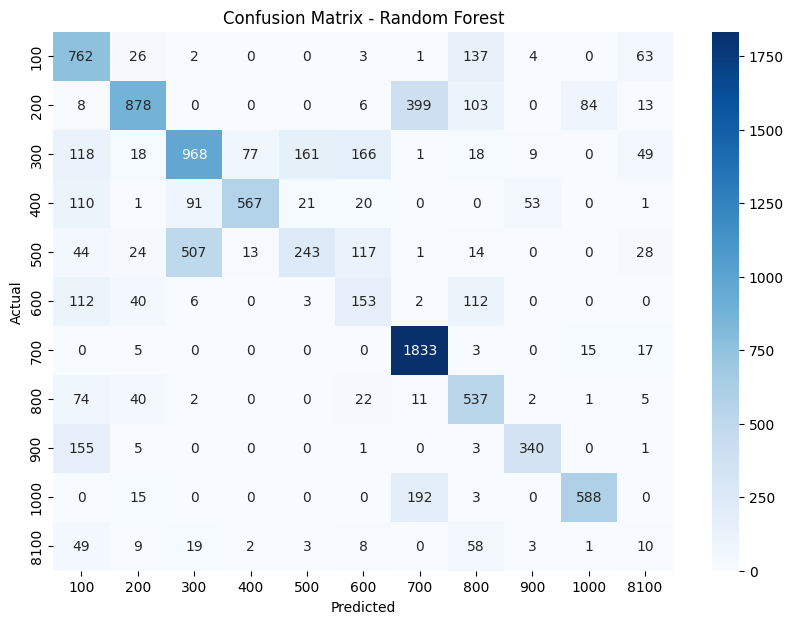


🔍 Đang huấn luyện mô hình: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         100       0.45      0.62      0.52       998
         200       0.35      0.18      0.24      1491
         300       0.45      0.11      0.18      1585
         400       0.95      0.30      0.45       864
         500       0.29      0.13      0.18       991
         600       0.12      0.22      0.15       428
         700       0.63      0.86      0.73      1873
         800       0.21      0.21      0.21       694
         900       0.16      0.31      0.21       505
        1000       0.38      0.57      0.46       798
        8100       0.03      0.14      0.04       162

    accuracy                           0.38     10389
   macro avg       0.37      0.33      0.31     10389
weighted avg       0.44      0.38      0.36     10389



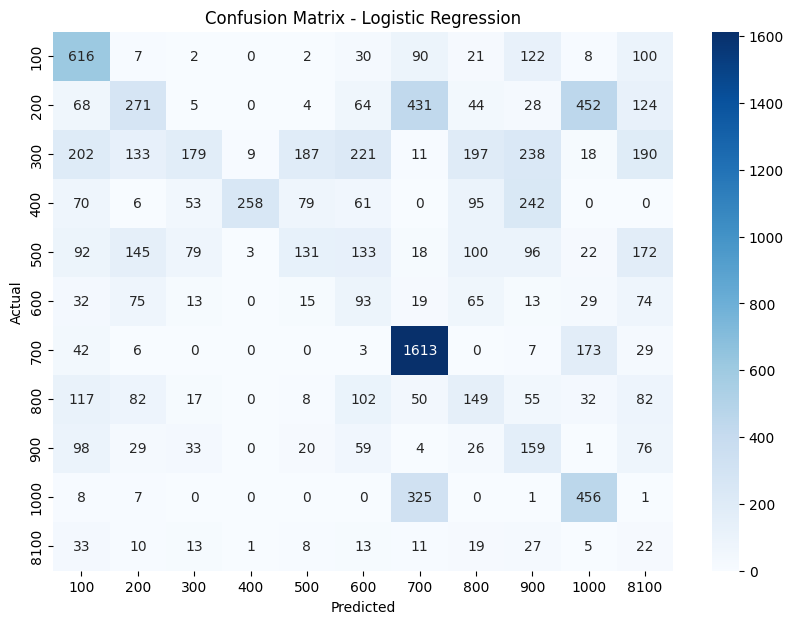


🔍 Đang huấn luyện mô hình: Extra Trees
              precision    recall  f1-score   support

         100       0.54      0.83      0.66       998
         200       0.77      0.54      0.64      1491
         300       0.63      0.62      0.62      1585
         400       0.87      0.68      0.76       864
         500       0.56      0.27      0.36       991
         600       0.24      0.23      0.23       428
         700       0.71      0.97      0.82      1873
         800       0.56      0.77      0.65       694
         900       0.82      0.70      0.76       505
        1000       0.80      0.69      0.74       798
        8100       0.11      0.06      0.07       162

    accuracy                           0.66     10389
   macro avg       0.60      0.58      0.57     10389
weighted avg       0.66      0.66      0.64     10389



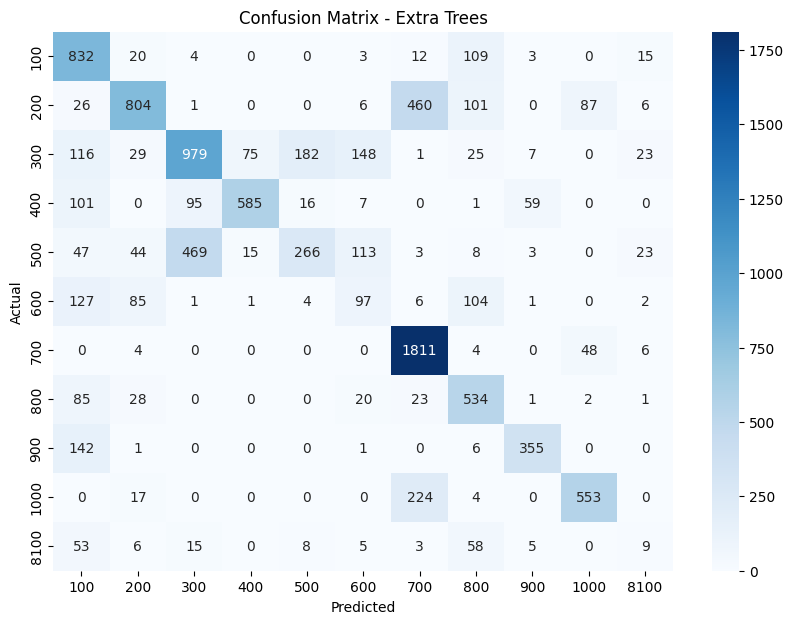


🔍 Đang huấn luyện mô hình: KNN (K-Nearest Neighbors)
              precision    recall  f1-score   support

         100       0.33      0.45      0.38       998
         200       0.35      0.24      0.29      1491
         300       0.36      0.15      0.21      1585
         400       0.70      0.28      0.40       864
         500       0.18      0.10      0.13       991
         600       0.07      0.15      0.10       428
         700       0.59      0.65      0.62      1873
         800       0.14      0.17      0.15       694
         900       0.15      0.19      0.17       505
        1000       0.31      0.43      0.36       798
        8100       0.03      0.14      0.05       162

    accuracy                           0.31     10389
   macro avg       0.29      0.27      0.26     10389
weighted avg       0.36      0.31      0.32     10389



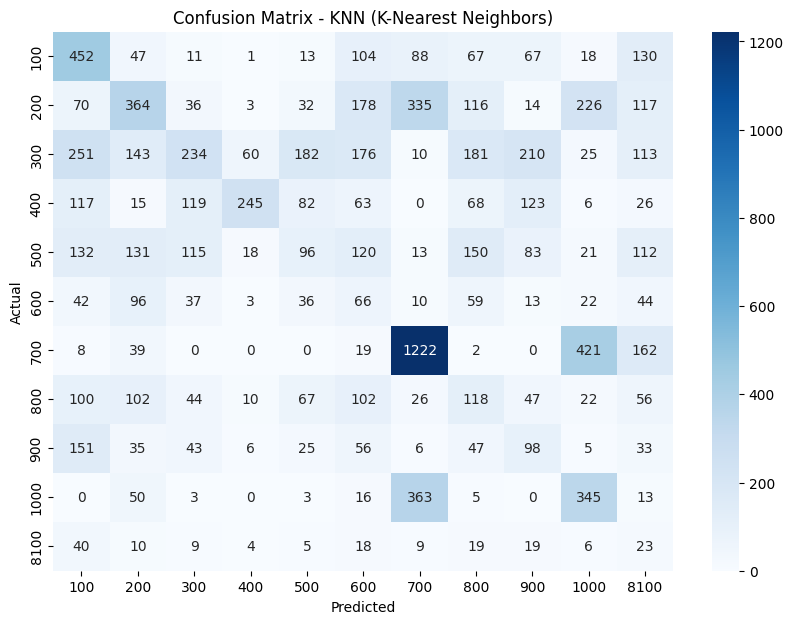


🔍 Đang huấn luyện mô hình: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:17:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:17:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         100       0.59      0.86      0.70       998
         200       0.86      0.63      0.73      1491
         300       0.63      0.69      0.66      1585
         400       0.85      0.71      0.77       864
         500       0.61      0.29      0.39       991
         600       0.38      0.36      0.37       428
         700       0.78      0.98      0.87      1873
         800       0.61      0.76      0.67       694
         900       0.90      0.77      0.83       505
        1000       0.83      0.74      0.78       798
        8100       0.05      0.04      0.05       162

    accuracy                           0.70     10389
   macro avg       0.64      0.62      0.62     10389
weighted avg       0.71      0.70      0.69     10389



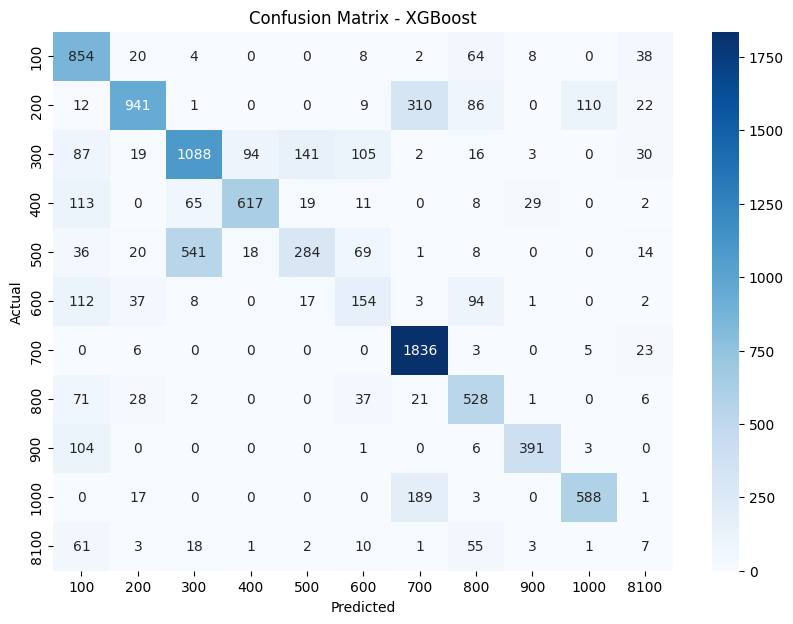


🔍 Đang huấn luyện mô hình: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29063
[LightGBM] [Info] Number of data points in the train set: 93687, number of used features: 114
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
              precision    recall  f1-score   support

         100       0.60

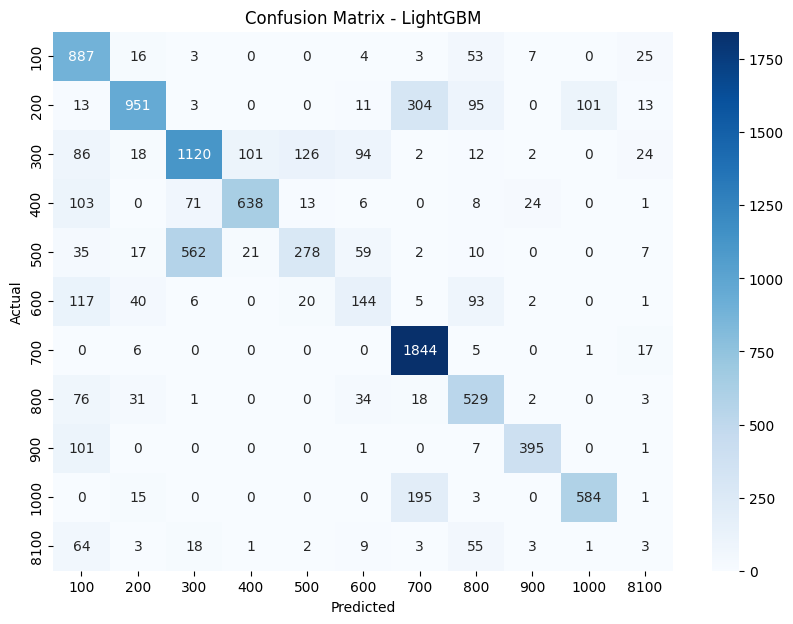

In [105]:
# Các model sẽ thử nghiệm
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier
     (
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        tree_method='hist',
        device='cuda'
    ),
    "LightGBM": LGBMClassifier
     (
        n_estimators=200,
        learning_rate=0.1
      )
}

# Huấn luyện và đánh giá từng model
for model_name, model in models.items():
    print(f"\n🔍 Đang huấn luyện mô hình: {model_name}")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_encoded = model.predict(X_test)

    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)

    print(classification_report(y_test_original, y_pred))

    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test_original, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()